In [ ]:
import os
import time

import cv2
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa
from skimage.io import imshow
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
tf.get_logger().setLevel('WARNING')
tf.keras.utils.disable_interactive_logging()

In [10]:
ASSET_FOLDER = '../assets/v2'
model = tf.keras.models.load_model('../assets/models/v2.keras')

# Create assertion dataset

In [4]:
ims = [cv2.cvtColor(cv2.imread(f'{ASSET_FOLDER}/{f}'), cv2.COLOR_BGR2GRAY) for f in os.listdir(ASSET_FOLDER) if 'bmp' in f]
lbs = ['OK' not in f for f in os.listdir(ASSET_FOLDER) if 'bmp' in f]

ok_org_ims = [im for l, im in zip(lbs, ims) if not l]
nok_org_ims = [im for l, im in zip(lbs, ims) if l]

amount = 100
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flips with a 50% probability
    iaa.Affine(rotate=(-90, 90)),  # Rotate the image between -45 and 45 degrees
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
], random_order=True)


def augment_image(image):
    augmented_image = seq(image=image)
    augmented_image = augmented_image.astype(np.uint8)
    return augmented_image

ok_ims = []
nok_ims = []
while True:
    for im in ok_org_ims:
        im = augment_image(im)
        ok_ims.append(im)
        if len(ok_ims) == amount:
            break
    if len(ok_ims) == amount:
        break
    

while True:
    for im in nok_org_ims:
        im = augment_image(im)
        nok_ims.append(im)
        if len(nok_ims) == amount:
            break
    if len(nok_ims) == amount:
        break

ims = [*ok_ims, *nok_ims]
lbs = [*np.zeros(amount), *np.ones(amount)]

Contaminated: 0.0


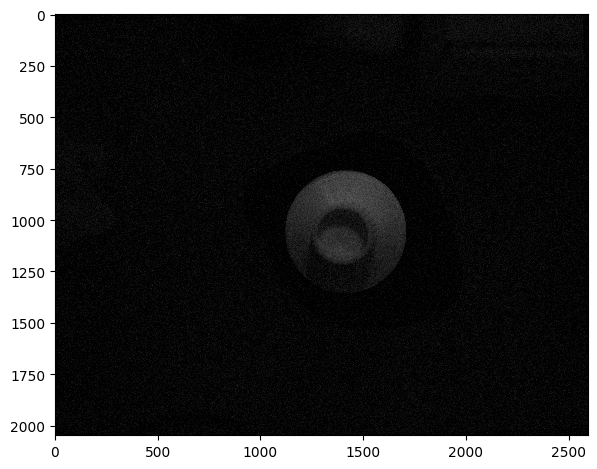

In [5]:
i = 0
print(f'Contaminated: {lbs[i]}')
imshow(ims[i])

# Threshold classifier

In [6]:
def is_contaminated_by_threshold(im, 
                     preprocess_threshold=30, 
                     final_threshold=92, 
                     cumulative_threshold=100, 
                     circle_radius=150):
    st = time.time()
    # Remove small noise via median filtering
    im = cv2.medianBlur(im, 3)

    # Drop background and possible artifacts
    im[im <= preprocess_threshold] = 0

    x, y = np.nonzero(im)
    xl,xr = x.min(),x.max()
    yl,yr = y.min(),y.max()
    im = im[xl:xr+1, yl:yr+1]

    center = (int(im.shape[0] / 2),  int(im.shape[1] / 2))   
    radius = circle_radius
    
    # Draw a circle mask
    im = cv2.circle(im, center, radius, (0, 0, 0), -1) 

    # Final threshold
    im[im <= final_threshold] = 0
    im[im > final_threshold] = 1

    # Resolve is contaminated or not
    res = np.sum(im) > cumulative_threshold
    et = time.time()
    return res, et-st


# CNN classifier

In [7]:
def is_contaminated_by_cnn(im,
                     preprocess_threshold=30, 
                     circle_radius=150):
    st = time.time()
    # Remove small noise via median filtering
    im = cv2.medianBlur(im, 3)

    # Drop background and possible artifacts
    im[im <= preprocess_threshold] = 0

    x, y = np.nonzero(im)
    xl,xr = x.min(),x.max()
    yl,yr = y.min(),y.max()
    im = im[xl:xr+1, yl:yr+1]

    center = (int(im.shape[0] / 2),  int(im.shape[1] / 2))   
    radius = circle_radius
    
    # Draw a circle mask
    im = cv2.circle(im, center, radius, (0, 0, 0), -1)

    # Resize
    im = cv2.resize(im, (90, 90))

    im = np.array([im])
    res = model.predict(im, )[0][0] >= 0.5
    et = time.time()
    return res, et-st


# Assert efficiency

## Collect results

In [11]:
print(is_contaminated_by_threshold(ims[0]))
print(is_contaminated_by_cnn(ims[0]))

(False, 0.08751988410949707)
(False, 0.37892746925354004)


In [9]:
threshold_res = []
threshold_time = []
for im in ims:
    res, ex_time = is_contaminated_by_threshold(im)
    threshold_res.append(res)
    threshold_time.append(ex_time)

In [12]:
cnn_res = []
cnn_time = []
for im in ims:
    res, ex_time = is_contaminated_by_cnn(im)
    cnn_res.append(res)
    cnn_time.append(ex_time)

## Evaluate results

In [13]:
print(f'Threshold mean execution time: {np.mean(threshold_time):.3f} [s]')
print(f'CNN mean execution time: {np.mean(cnn_time):.3f} [s]')

Threshold mean execution time: 0.045 [s]
CNN mean execution time: 0.131 [s]


### Threshold results

In [14]:
y = np.array(lbs).astype(bool)
pred = threshold_res

print(f'Accuracy score: {accuracy_score(pred, y)}')

cf_mat = confusion_matrix(y, pred)
print('Confusion matrix')
print(cf_mat)
print(f'class 0 accuracy: {cf_mat[0][0]/(len(lbs)-sum(lbs))}')
print(f'class 1 accuracy: {cf_mat[1][1]/sum(lbs)}')

Accuracy score: 1.0
Confusion matrix
[[100   0]
 [  0 100]]
class 0 accuracy: 1.0
class 1 accuracy: 1.0


### CNN results

In [15]:
y = np.array(lbs).astype(bool)
pred = cnn_res

print(f'Accuracy score: {accuracy_score(pred, y)}')

cf_mat = confusion_matrix(y, pred)
print('Confusion matrix')
print(cf_mat)
print(f'class 0 accuracy: {cf_mat[0][0]/(len(lbs)-sum(lbs))}')
print(f'class 1 accuracy: {cf_mat[1][1]/sum(lbs)}')

Accuracy score: 0.905
Confusion matrix
[[100   0]
 [ 19  81]]
class 0 accuracy: 1.0
class 1 accuracy: 0.81
